## Training Neural Networks

(in TensorFlow)



In [1]:
import numpy as np
from matplotlib import pyplot as plt

# choose a different matplotlib style (all styles can be found at https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)
#print(plt.style.available)  # uncomment to see available styles
plt.style.use('dark_background')

### Some Toy Dataset

We will focus on tabular data first, i.e. data that is arranged in rows and tables (no time series yet). As such, we can map a set of inputs $x=[x_1, ..., x_n]$ to outputs $y=[y_1, ..., y_m]$. We will have $N$ data samples. 

**Modeling Task**: translate a sinusoidal input signal $u=\sin(\omega t)$ to $q=\omega\sin(\omega t)^2$. 

*Note:* 
- this problem does not involve any memory
- this problem is clearly nonlinear

The model should be able to solve the task for variable frequencies $\omega_j$. We draw the frequencies randomly from a range of values.  

Model setup: the model receives a single input signal $u_i = \sin(\omega_j t_i)$ and the corresponding frequency $\omega_j$. The output is the corresponding transformed signal $q_i=\omega_j \sin(\omega_j t_i)^2$. 

`x = [u, omega]`, shape: `[2,1]`

`y = [q]`, shape: `[1,1]` 




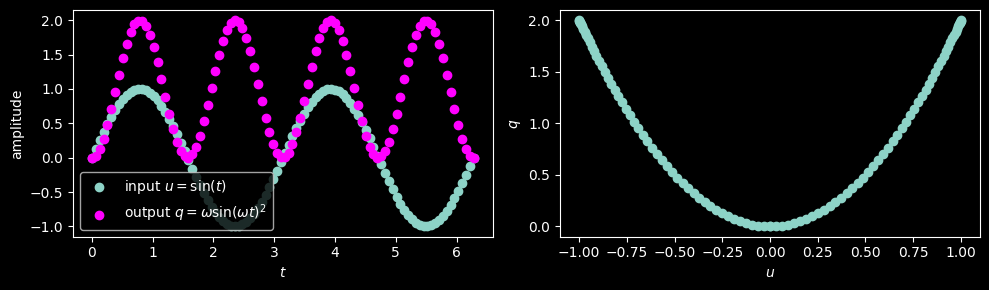

In [2]:
def nonlinear_transform(u, omega):
    """A simple nonlinear transformation."""
    return u**2 * omega

omega = 2.0
t = np.linspace(0, 2 * np.pi, int(omega*50))
u = np.sin(omega*t)
q = nonlinear_transform(u, omega)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(t, u, label=r'input $u = \sin(t)$')
plt.scatter(t, q, label=r'output $q = \omega \sin(\omega t)^2$', color='magenta')
plt.xlabel(r'$t$')
plt.ylabel('amplitude')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(u, q)
plt.xlabel(r'$u$')
plt.ylabel(r'$q$')
plt.tight_layout()
plt.show()


In [3]:

def create_dataset(n_samples, freq_range=(1.0, 5.0)):
    """
    Generates a dataset for the nonlinear transformation of a sine signal.
    As no time dependence is given, we sample frequencies and times uniformly.
    There is no strict need to compute full sine wave, just the values at sampled points.
    
    Args:
        n_samples (int): Number of samples to generate.
        freq_range (tuple): (min_freq, max_freq) for omega sampling.
        
    Returns:
        X (np.ndarray): shape (n_samples, 2), columns [u, omega]
        y (np.ndarray): shape (n_samples, 1), column [q]
    """
    
    # time range for the sine wave
    t_min=0 
    t_max=2*np.pi
    
    omegas = np.random.uniform(freq_range[0], freq_range[1], size=n_samples)
    ts = np.random.uniform(t_min, t_max, size=n_samples)
    u = np.sin(omegas * ts)
    q = nonlinear_transform(u=u, omega=omegas)
    x = np.stack([u, omegas], axis=1)
    y = q.reshape(-1, 1)
    return x, y

### Create a training and test set

We will train the model on the training set, and evaluate predictions on the test set to assess the generalization properties. The validation set is used to stop training. We split according to a 70-15-15 ratio. 

It is highly recommended to use sklearn's splitting functionalities, particularly the stratified splitting when working with classification problems.

In [4]:
from sklearn.model_selection import train_test_split

# Create the dataset
x, y = create_dataset(n_samples=10000)

# Split the dataset into training and test sets
# Train/Val/Test Split using sklearn
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f'shape of x: {x.shape}')
print(f'shape of y: {y.shape}')
print(f'number of training samples: {len(x_train)}')
print(f'number of validation samples: {len(x_val)}')
print(f'number of test samples: {len(x_test)}')


shape of x: (10000, 2)
shape of y: (10000, 1)
number of training samples: 7000
number of validation samples: 1500
number of test samples: 1500


### Fitting a neural network estimator ("training")

We are fitting a vanilla-type artificial neural network, i.e. a feedforward neural net, to the given data using the Keras API. The network has the following structure: 
1. Input layer
2. First hidden layer with 64 neurons and sigmoid activation function
3. Second hidden layer with 32 neurons and sigmoid activation function
4. Output layer having as many neurons as we have output quantities (1 here)

**Important**:
- input shape to the network is `[2,]`, i.e. 2 features. 
- output shape of the network is `[1,]`, i.e. 1 target.
- regression problem: use the `linear` activation function in the output layer


#### Loss functions
--> steer the optimization process towards a local minimum w.r.t. to the chosen loss function. Candidates: MSE; MAE; Huber

#### Metrics
--> scoring functions evaluated along the training process. Do not affect the training at all, as they are just "observing". 

#### Early stopping
Prevents the model from overfitting to the training data. Stops training once the validation loss does not decrease for some `patience` number of epochs. 


In [5]:
from tensorflow.keras.models import Sequential  # the model class
from tensorflow.keras.layers import Dense, Input  # the layers we will use
from tensorflow.keras.callbacks import EarlyStopping # for early stopping during training

input_shape = x_train.shape[1]  # number of input features ()
output_shape = y_train.shape[1]  # number of output features (1)

# Create a simple feedforward neural network model (using the Sequential API)
model = Sequential()
model.add(Input(shape=(input_shape,)))  # input layer <-- always needed!
model.add(Dense(64, activation='sigmoid'))  # hidden layer with 64 neurons and sigmoid activation
model.add(Dense(32, activation='tanh'))  # another hidden layer with 32 neurons and tanh activation
model.add(Dense(output_shape, activation='linear'))  # output layer with linear activation (default)

# Compile the model with mean squared error loss and Adam optimizer
model.compile(loss='mean_squared_error',  # loss function
              metrics=['mean_absolute_error'],  # metrics to monitor during training
              optimizer='adam')

# Print the model summary to see the architecture
model.summary()

# Define Early Stopping Callback. Stops training when the validation loss does not improve 
# for a given number of epochs.
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5,  # for how many epochs to wait for improvement
                           verbose=2,
                           restore_best_weights=True, # reclaim the best weights after stopping, not the last weights
                           )

# Train the model on the training data. The returned `history` object contains training metrics.
history = model.fit(x_train, y_train, # training data
                    validation_data=(x_val, y_val), # validation data to monitor performance on unseen data
                    epochs=400, # how many times to iterate over the training data
                    batch_size=512,  # how many samples to process before updating the model weights 
                    verbose=2,  # verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)
                    callbacks=[early_stop], # use early stopping
                    )  

# store the model to disk
model.save('best_sine_transformation_model.keras')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,305 (9.00 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
14/14 - 1s - 44ms/step - loss: 2.9061 - mean_absolute_error: 1.3208 - val_loss: 1.6116 - val_mean_absolute_error: 1.0898
Epoch 2/400
14/14 - 0s - 5ms/step - loss: 1.7486 - mean_absolute_error: 1.1474 - val_loss: 1.5873 - val_mean_absolute_error: 1.0789
Epoch 3/400
14/14 - 0s - 5ms/step - loss: 1.5568 - mean_absolute_error: 1.0351 - val_loss: 1.5417 - val_mean_absolute_error: 1.0111
Epoch 4/400
14/14 - 0s - 5ms/step - loss: 1.5274 - mean_absolute_error: 1.0208 - val_loss: 1.4909 - val_mean_absolute_error: 1.0238
Epoch 5/400
14/14 - 0s - 5ms/step - loss: 1.4933 - mean_absolute_error: 1.0263 - val_loss: 1.4680 - val_mean_absolute_error: 1.0116
Epoch 6/400
14/14 - 0s - 5ms/step - loss: 1.4669 - mean_absolute_error: 1.0090 - val_loss: 1.4470 - val_mean_absolute_error: 1.0022
Epoch 7/400
14/14 - 0s - 5ms/step - loss: 1.4420 - mean_absolute_error: 1.0033 - val_loss: 1.4260 - val_mean_absolute_error: 0.9966
Epoch 8/400
14/14 - 0s - 5ms/step - loss: 1.4177 - mean_absolute_error: 0.9

#### Visualize the NN training run

We have trained the NN to reduce the MSE error on the training set. During each optimization iteration, we have also used the current model weights to make predictions on the hold-out test set. Hence, we can study how well the model generalizes to new unseen data points, and identify the point at which overfitting sets in (loss for training set decreases, loss for test set increases).

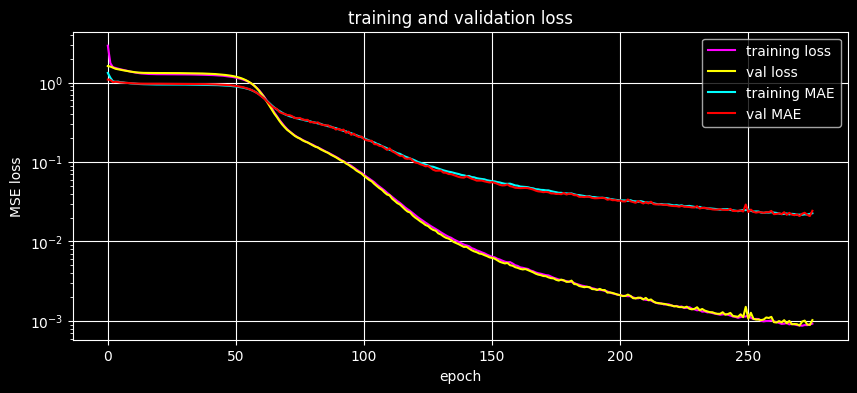

In [6]:

# Plot the training and test loss over epochs
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='training loss', color='magenta')
plt.plot(history.history['val_loss'], label='val loss', color='yellow')

plt.plot(history.history['mean_absolute_error'], label='training MAE', color='cyan')
plt.plot(history.history['val_mean_absolute_error'], label='val MAE', color='red')

plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.yscale('log')  # use logarithmic scale for better visibility of loss values
plt.title('training and validation loss')
plt.grid()
plt.show()

### Evaluate the model

Let's see how well the model can make predictions on data that was not used for training, i.e. on the test set samples. 

To make predictions, call `model.predict(x)`, where is are new inputs.

For regression tasks the $R^2$ score is the most-used metric, ranging from $0.0$ (not better than predicting the average target value) to $1.0$ (perfect mdoel).

We will use a plot that shows the predicted against the expected (i.e. ground truth targets) values. A perfect model would result in the identity line. 

In [7]:
# load the model from disk (if needed)
from tensorflow.keras.models import load_model
model = load_model('best_sine_transformation_model.keras')

# plot the predictions vs. ground truth
y_pred = model.predict(x_test)

# evaluate the R2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2:.4f}')


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R2 score: 0.9994


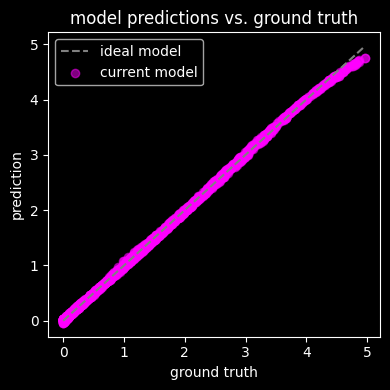

In [8]:

plt.figure(figsize=(4, 4))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='gray', linestyle='--', label='ideal model')
plt.xlabel(r'ground truth')
plt.ylabel(r'prediction')
plt.scatter(y_test, y_pred, alpha=0.5, color='magenta', label='current model')
plt.title('model predictions vs. ground truth')
plt.legend()
plt.tight_layout()
plt.show()



### Deploy model for predictions

We will use the model to compute the phase-shift of a complete sinusoidal time sequence.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


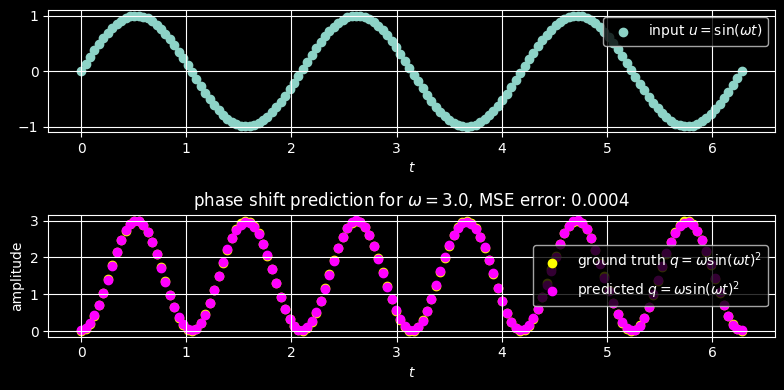

In [9]:

omega = 3.0
t_new = np.linspace(0, 2 * np.pi, int(omega*50))
u_new = np.sin(omega * t_new)
q_new = nonlinear_transform(u=u_new, omega=omega)  # compute the ground truth q values for the new u values

inputs = np.column_stack((u_new, np.ones_like(u_new)*omega))

# Use the model to predict q for the new u values
q_pred = model.predict(inputs)

# Compute the mean squared error of the predictions
mse_err = np.mean((q_new - q_pred.flatten()) ** 2)


# plot the new data and the model predictions
plt.figure(figsize=(8, 4))
plt.subplot(2,1, 1)
plt.scatter(t_new, u_new, label=r'input $u = \sin(\omega t)$')
plt.xlabel(r'$t$')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.scatter(t_new, q_new, label=r'ground truth $q = \omega \sin(\omega t)^2$', color='yellow')
plt.scatter(t_new, q_pred, label=r'predicted $q = \omega \sin(\omega t)^2$', color='magenta')
plt.xlabel(r'$t$')
plt.ylabel('amplitude') 
plt.legend()
plt.grid()
plt.title(fr'phase shift prediction for $\omega = {omega}$, MSE error: {mse_err:.4f}')
plt.tight_layout()
plt.show()

### Model architecture search (+ hyperparameter optimization)

Use k-fold cross-validation to search for good models and hyperparameters

In [10]:

from sklearn.model_selection import KFold


### define a model generator

that will return instances of TF models with different hyperparameters

In [11]:
def build_model(input_dim, output_dim, hidden_layers):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # input layer
    for units in hidden_layers:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(1))  # output layer

    # Compile the model with mean squared error loss and Adam optimizer
    model.compile(loss='mean_squared_error',  # loss function
                metrics=['mean_absolute_error'],  # metrics to monitor during training
                optimizer='adam')

    return model

# Define Early Stopping Callback. Stops training when the validation loss does not improve 
# for a given number of epochs.
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5,  # for how many epochs to wait for improvement
                           verbose=2,
                           restore_best_weights=True, # reclaim the best weights after stopping, not the last weights
                           )


### Speficy models to search



In [12]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
architectures = {
    "shallow": [32],
    "medium": [64, 32],
    "deep": [32, 64, 32]
}



### Run k-fold CV

In [13]:
# store results for each architecture
results = {name: [] for name in architectures}

# Evaluate different architectures using K-Fold Cross-Validation
for name, layers in architectures.items():
    print(f"Evaluating architecture: {name}")
    for train_index, val_index in kf.split(x):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model = build_model(x.shape[1], y.shape[1], layers)
        history = model.fit(x_train, y_train, # training data
                    validation_data=(x_val, y_val), # validation data to monitor performance on unseen data
                    epochs=400, # how many times to iterate over the training data
                    batch_size=256,  # how many samples to process before updating the model weights 
                    verbose=2,  # verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)
                    callbacks=[early_stop], # use early stopping
                    )  
        mse = model.evaluate(x_val, y_val, verbose=0)[0]  # get the MSE loss on the test set
        print(f"Fold MSE: {mse:.4f}")
        results[name].append(mse)

    print(f"Avg MSE for {name}: {np.mean(results[name]):.4f}")


Evaluating architecture: shallow
Epoch 1/400
32/32 - 1s - 22ms/step - loss: 1.7633 - mean_absolute_error: 1.0546 - val_loss: 1.4021 - val_mean_absolute_error: 0.9878
Epoch 2/400
32/32 - 0s - 3ms/step - loss: 1.3183 - mean_absolute_error: 0.9628 - val_loss: 1.3158 - val_mean_absolute_error: 0.9716
Epoch 3/400
32/32 - 0s - 3ms/step - loss: 1.2893 - mean_absolute_error: 0.9523 - val_loss: 1.3045 - val_mean_absolute_error: 0.9647
Epoch 4/400
32/32 - 0s - 3ms/step - loss: 1.2693 - mean_absolute_error: 0.9419 - val_loss: 1.2642 - val_mean_absolute_error: 0.9465
Epoch 5/400
32/32 - 0s - 3ms/step - loss: 1.2169 - mean_absolute_error: 0.9221 - val_loss: 1.2166 - val_mean_absolute_error: 0.9290
Epoch 6/400
32/32 - 0s - 3ms/step - loss: 1.1819 - mean_absolute_error: 0.9088 - val_loss: 1.1877 - val_mean_absolute_error: 0.9167
Epoch 7/400
32/32 - 0s - 3ms/step - loss: 1.1542 - mean_absolute_error: 0.8963 - val_loss: 1.1590 - val_mean_absolute_error: 0.9040
Epoch 8/400
32/32 - 0s - 3ms/step - loss: 

### Evaluate CV

In [14]:
for name in results:
    print(f"{name}: Mean MSE = {np.mean(results[name]):.4f}, Std = {np.std(results[name]):.4f}")


shallow: Mean MSE = 0.0022, Std = 0.0010
medium: Mean MSE = 0.0002, Std = 0.0001
deep: Mean MSE = 0.0002, Std = 0.0001
